# Task1 Data loading

In [1]:
import pandas as pd
from scipy.stats import zscore
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import numpy as np
import psycopg2
import psycopg2.extras
import json
import math


def sigmoid(x):
  return 1 / (1 + math.exp(-x))


credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['database']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

db, conn = pgconnect(credentials)

Connected successfully.


In [2]:
# create schema, set path to greatersydney and postgis exteension in that schema
conn.execute("""
create schema if not exists GreaterSydney ;
drop  extension if exists postgis cascade;
create extension postgis schema GreaterSydney;
set search_path to GreaterSydney;

""")
# create table for  SA2 Regions , income , population, businesses, future school, primary shool, secondary school, polls and stops
conn.execute("""

drop table if exists sa2_region cascade;
create table sa2_region(
SA2_CODE      integer primary key ,
SA2_NAME      varchar(50),
CHG_FLAG      integer,
CHG_LBL       varchar(50),
SA3_CODE      integer,
SA3_NAME      varchar(50),
SA4_CODE       integer,
SA4_NAME      varchar(50),
GCC_CODE      varchar(50),
GCC_NAME      varchar(50),
STE_CODE       integer,
STE_NAME      varchar(50),
AUS_CODE      varchar(50),
AUS_NAME      varchar(50),
AREASQKM     float,
LOCI_URI      varchar(100),
geom      GEOMETRY(MULTIPOLYGON,4326)
)""")

conn.execute( """
drop table if exists income;
create table income (
sa2_code Integer  primary key references sa2_region(sa2_code),
sa2_name Varchar(50),
earners Integer,
median_age Integer,
median_income float,
mean_income float

);""")

conn.execute( """
drop table if exists population;
create table population (
sa2_code Integer primary key references sa2_region(sa2_code),
sa2_name Varchar(50),
"0-4_people"             Integer,
"5-9_people"             Integer,
"10-14_people"           Integer,
"15-19_people"           Integer,
"20-24_people"           Integer,
"25-29_people"           Integer,
"30-34_people"           Integer,
"35-39_people"           Integer,
"40-44_people"          Integer,
"45-49_people"          Integer,
"50-54_people"          Integer,
"55-59_people"          Integer,
"60-64_people"         Integer,
"65-69_people"           Integer,
"70-74_people"           Integer,
"75-79_people"           Integer,
"80-84_people"           Integer,
"85-and-over_people"     Integer,
total_people           Integer
);""")

conn.execute("""

drop table if exists businesses;
create table businesses(
industry_code             varchar(1) ,
industry_name             varchar(80),
sa2_code                   integer references sa2_region(sa2_code),
sa2_name                  varchar(80),
"0_to_50k_businesses"         integer,
"50k_to_200k_businesses"      integer,
"200k_to_2m_businesses"       integer,
"2m_to_5m_businesses"        integer,
"5m_to_10m_businesses"        integer,
"10m_or_more_businesses"      integer,
total_businesses            integer


)""")

conn.execute("""

drop table if exists future_school;
create table future_school(
USE_ID                Integer primary key,
CATCH_TYPE            Varchar(50),
USE_DESC              Varchar(50),
ADD_DATE               date,
KINDERGART             Integer,
YEAR1                  Integer,
YEAR2                  Integer,
YEAR3                  Integer,
YEAR4                  Integer,
YEAR5                Integer,
YEAR6                  Integer,
YEAR7                  Integer,
YEAR8                  Integer,
YEAR9                  Integer,
YEAR10                 Integer,
YEAR11                 Integer,
YEAR12                 Integer,
geom            GEOMETRY(MULTIPOLYGON,4326)
)""")

conn.execute("""

drop table if exists primary_school;
create table primary_school(
USE_ID                Integer primary key,
CATCH_TYPE            Varchar(50),
USE_DESC             Varchar(50),
ADD_DATE               date,
KINDERGART             Varchar(1),
YEAR1                 Varchar(1),
YEAR2                  Varchar(1),
YEAR3                  Varchar(1),
YEAR4                  Varchar(1),
YEAR5                Varchar(1),
YEAR6                  Varchar(1),
YEAR7                  Varchar(1),
YEAR8                  Varchar(1),
YEAR9                  Varchar(1),
YEAR10                 Varchar(1),
YEAR11                 Varchar(1),
YEAR12               Varchar(1),
PRIORITY               Varchar(50),
geom            GEOMETRY(MULTIPOLYGON,4326)
)""")

conn.execute("""

drop table if exists secondary_school;
create table secondary_school(
USE_ID                Integer primary key,
CATCH_TYPE            Varchar(50),
USE_DESC             Varchar(50),
ADD_DATE               date,
KINDERGART             Varchar(1),
YEAR1                 Varchar(1),
YEAR2                  Varchar(1),
YEAR3                  Varchar(1),
YEAR4                  Varchar(1),
YEAR5                Varchar(1),
YEAR6                  Varchar(1),
YEAR7                  Varchar(1),
YEAR8                  Varchar(1),
YEAR9                  Varchar(1),
YEAR10                 Varchar(1),
YEAR11                 Varchar(1),
YEAR12               Varchar(1),
PRIORITY               Varchar(50),
geom             GEOMETRY(MULTIPOLYGON,4326)
)""")

conn.execute("""

drop table if exists polls;
create table polls(
FID                             varchar(100) primary key,
state                           varchar(100),
division_id                      integer,
division_name                   varchar(100),
polling_place_id                 integer,
polling_place_type_id            integer,
polling_place_name              varchar(100),
premises_name                   varchar(100),
premises_address_1              varchar(100),
premises_address_2              varchar(100),
premises_address_3              varchar(100),
premises_suburb                varchar(100),
premises_state_abbreviation     varchar(100),
premises_post_code             float,
latitude                       float,
longitude                      float,
geom             GEOMETRY(POINT,4326)
)""")

conn.execute("""

drop table if exists stops;
create table stops(
stop_id                  varchar(80) primary key,
stop_code               integer,
stop_name                varchar(80),
stop_lat                float,
stop_lon                float,
location_type           float,
parent_station          varchar(80),
wheelchair_boarding       integer,
platform_code            varchar(80),
geom             GEOMETRY(POINT,4326)
)""")



print('successfully created shema and tables')

successfully created shema and tables


In [3]:
srid = 4326
def create_wkt_element(geom, srid):
    if geom is not None:
        if geom.geom_type == 'Polygon':
            geom = MultiPolygon([geom])
        return WKTElement(geom.wkt, srid)
    else:
        return None
incomes_df = pd.read_csv("Income.csv" )
population_df = pd.read_csv('Population.csv')
schools_future_df = gpd.read_file("Catchments/catchments/catchments_future.shp")
primary_df = gpd.read_file("Catchments/catchments/catchments_primary.shp")
secondary_df = gpd.read_file("Catchments/catchments/catchments_secondary.shp")
polls_df = pd.read_csv("PollingPlaces2019.csv")
businesses_df = pd.read_csv('Businesses.csv')
stops_df = pd.read_csv('Stops.txt' )
SA2_df = gpd.read_file('SA2_2021_AUST_GDA2020.shp')
# load local files into df

SA2_df= SA2_df.rename(columns=str.lower)
SA2_df = SA2_df.rename(columns = lambda x: str(x)[0:-2])
SA2_df = SA2_df.loc[SA2_df['gcc_name'] == 'Greater Sydney']
SA2_df['geom'] = SA2_df['geomet'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
SA2_df = SA2_df.drop(columns="geomet")
SA2_df['sa2_code'] = SA2_df['sa2_code'].astype('int')
# set the colum name to lower case to prevent importing errors caused by upper case
# remove the 21 after each column to maintain consistencies in the schema as 21 is just the year of the data published
# filter the sa2_resion down to "Greater Sydney"
# convert geom to WKT format to streamline the spatial data importing process

for items in incomes_df.columns:
    incomes_df[items].replace(to_replace = 'np', value = None, inplace = True)
# set the null value in incomes to None

schools_future_df= schools_future_df.rename(columns=str.lower)
schools_future_df['add_date']= pd.to_datetime(schools_future_df['add_date'],format="%Y%m%d")
schools_future_df['geom'] = schools_future_df['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
schools_future_df = schools_future_df.drop(columns="geometry")
# set the colum name to lower case to prevent importing errors caused by upper case
# change the dtype for add_date to datetime so it can be imported as date in postgresql
# convert geom to WKT format to streamline the spatial data importing process

primary_df= primary_df.rename(columns=str.lower)
primary_df['add_date']= pd.to_datetime(primary_df['add_date'],format="%Y%m%d")
primary_df['geom'] = primary_df['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
primary_df = primary_df.drop(columns="geometry")
# set the colum name to lower case to prevent importing errors caused by upper case
# change the dtype for add_date to datetime so it can be imported as date in postgresql
# convert geom to WKT format to streamline the spatial data importing process

secondary_df= secondary_df.rename(columns=str.lower)
secondary_df['add_date']= pd.to_datetime(secondary_df['add_date'],format="%Y%m%d")
secondary_df['geom'] = secondary_df['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
secondary_df = secondary_df.drop(columns="geometry")
# set the colum name to lower case to prevent importing errors caused by upper case
# change the dtype for add_date to datetime so it can be imported as date in postgresql
# convert geom to WKT format to streamline the spatial data importing process

polls_df= polls_df.rename(columns=str.lower)
polls_df['geom'] = gpd.points_from_xy(polls_df.longitude , polls_df.latitude)  # creating the geometry column
polls_df = polls_df.drop(columns=['the_geom'])
polls_df['geom'] = polls_df['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))  
# set the colum name to lower case to prevent importing errors caused by upper case
# create point using latitude and longitude in geom column
# convert geom to WKT format to streamline the spatial data importing process

stops_df['geom'] = gpd.points_from_xy(stops_df.stop_lon , stops_df.stop_lat)
stops_df['geom'] = stops_df['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid)) 
# create point using latitude and longitude in geom column
# convert geom to WKT format to streamline the spatial data importing process

key = SA2_df['sa2_code']
# produce all sa2_code in greatersydeny
columns = population_df.columns
joined_population = pd.merge(population_df, key, on = 'sa2_code')
population_df = joined_population[columns]

columns = incomes_df.columns
joined_incomes = pd.merge(incomes_df, key, on = 'sa2_code')
incomes_df = joined_incomes[columns]

columns = businesses_df.columns
joined_businesses = pd.merge(businesses_df, key, on = 'sa2_code')
businesses_df = joined_businesses[columns]
#filter out columns in businesses,population and incomes that are not in greatersydney

print('Data cleaning complete.')

Data cleaning complete.


In [4]:
secondary_df.to_sql('secondary_school', conn, if_exists='append',index=False ,dtype={'geom': Geometry('MULTIPOLYGON', srid)})
primary_df.to_sql('primary_school', conn, if_exists='append',index=False ,dtype={'geom': Geometry('MULTIPOLYGON', srid)})
SA2_df.to_sql('sa2_region', conn, if_exists='append',index=False ,dtype={'geom': Geometry('MULTIPOLYGON', srid)})
stops_df.to_sql('stops', conn, if_exists='append',index=False ,dtype={'geom': Geometry('Point', srid)})
incomes_df.to_sql('income', conn, if_exists='append',index=False)
population_df.to_sql('population', conn, if_exists='append',index=False)
schools_future_df.to_sql('future_school', conn, if_exists='append',index=False ,dtype={'geom': Geometry('MULTIPOLYGON', srid)})
polls_df.to_sql('polls', conn, if_exists='append',index=False ,dtype={'geom': Geometry('Point', srid)})
businesses_df.to_sql('businesses', conn, if_exists='append',index=False )
#  load data into postgresql

87

# Task 2 Score calculation

In [5]:
retail_bus_per1000= pd.read_sql("""
select sa2_code , case when total_people  <100 then null else cast(retail_businesses as float)/cast(total_people as float)/1000 end as retail_businesses_per_1000_people
from population natural join 
(select sa2_code,sum(total_businesses ) as retail_businesses
from businesses natural join population
where lower(industry_name) like '%%retail%%' 
group by sa2_code) as retail
""" , conn)
# query first found the number of retail businesses in each sa2_region then find the number of people in each region, then 
# if the people in the region is less than query returns null else it divides the nunmber of retail businesses using the number
# people in that region and divide by a thousand to get Retail businesses per 1000 people 
retail_bus_per1000['retail_zscore']= zscore(retail_bus_per1000.loc[retail_bus_per1000['retail_businesses_per_1000_people'].notnull()]['retail_businesses_per_1000_people'])
# find the z score for Retail businesses per 1000 people (excludes the population below 100)
retail_bus_per1000=retail_bus_per1000.dropna()
# remove the sa2_region without zscore and Retail businesses per 1000 people 
retail_bus_per1000 = retail_bus_per1000.drop(columns='retail_businesses_per_1000_people')

In [6]:
health_bus_per1000= pd.read_sql("""
select sa2_code, case when total_people < 100 then null else cast(health_businesses as float)/cast(total_people as float)/1000 end as health_businesses_per_1000_people
from population natural join 
(select sa2_code,sum(total_businesses ) as health_businesses
from businesses natural join population
where lower(industry_name) like '%%health%%' 
group by sa2_code) as health
""" , conn)
# query first found the number of health services in each sa2_region then find the number of people in each region, then 
# if the people in the region is less than query returns null else it divides the nunmber of health services using the number
# people in that region and divide by a thousand to get Health services per 1000 people
health_bus_per1000['health_zscore']= zscore(health_bus_per1000.loc[health_bus_per1000['health_businesses_per_1000_people'].notnull()]['health_businesses_per_1000_people'])
# find the z score for Health services per 1000 people (excludes the population below 100)
health_bus_per1000=health_bus_per1000.dropna()
# remove the sa2_region without zscore and Health services per 1000 people 
health_bus_per1000=health_bus_per1000.drop(columns = 'health_businesses_per_1000_people')

In [7]:
stops_sa2 = pd.read_sql("""
drop index  if exists sa2;
drop index if exists stop;
create index sa2 on sa2_region using gist(geom);
create index stop on stops using gist(geom);
select sa2_code , count(stop_id)  from stops s right outer join sa2_region r on(ST_Contains(r.geom,s.geom)) 
group by sa2_code """,conn)
stops_sa2['stops_zscore']= zscore(stops_sa2['count'])
stops_sa2=stops_sa2.drop(columns = 'count')
# find the number of stops in each sa2_region and calculate the z score for them

In [8]:
polls_sa2 = pd.read_sql("""select sa2_code , count(fid)  from sa2_region r left outer join polls p on (ST_Contains(r.geom,p.geom))  
group by sa2_code """,conn)
polls_sa2['polls_zscore']= zscore(polls_sa2['count'])
polls_sa2=polls_sa2.drop(columns = 'count')
#find the number of polls in each sa2_region and calculate the z score for them

In [9]:
school_sa2 = pd.read_sql("""
select young.sa2_code, case when young_people <100 then Null
else cast(total_school as float)/cast(young_people as float)/1000 end as school_per_1000_young_people
from (select sa2_code , ("0-4_people"  + "5-9_people" + "10-14_people" + "15-19_people" ) as young_people 
      from  population ) as young natural join 
(select primary_sa2.sa2_code , prim + future+ secon as total_school 
from 
(select sa2_code , count(use_id) as prim from sa2_region r left outer join primary_school s
on(ST_Intersects(s.geom,r.geom)) 
group by sa2_code) as primary_sa2 natural join

(select sa2_code , count(use_id) as future from sa2_region r left outer join future_school s
on(ST_Intersects(s.geom ,r.geom)) 
group by sa2_code) as future_sa2 natural join

(select sa2_code , count(use_id) as secon from sa2_region r left outer join secondary_school s
on(ST_Intersects(s.geom ,r.geom)) 
group by sa2_code) as secondary_sa2 
) as total""",conn)
# WE use ST_intersects so when a shcool crosses two region it gets counted one time for each region. This is because that school
# can potentially benefit people in both region so it should be counted as a resource for both region
# query first found the number of secondary,primary and future school in each sa2_region and add them together to produce the
#total number of schools in the region. Then it find the total number of young people and caluculate the  School catchments areas per 1000 ’young people
# by usisng the total number of school divided by number of young people and a thousand. If the region has less than 100
# young people it gets excluded
school_sa2['school_zscore']= zscore(school_sa2.loc[school_sa2['school_per_1000_young_people'].notnull()]['school_per_1000_young_people'])
school_sa2=school_sa2.dropna()
# find zscore for  School catchments areas per 1000 ’young people and remove region that has less than 100 young people
school_sa2=school_sa2.drop(columns='school_per_1000_young_people')


In [10]:
total_zscore = retail_bus_per1000.merge(health_bus_per1000,on='sa2_code').merge(stops_sa2,on='sa2_code').merge(polls_sa2,on='sa2_code').merge(school_sa2,on='sa2_code')
total_zscore['sum_zscore'] = total_zscore['retail_zscore']+total_zscore['health_zscore']+total_zscore['stops_zscore']+total_zscore['polls_zscore']+total_zscore['school_zscore']
total_zscore['score'] = total_zscore['sum_zscore'].apply(lambda x: sigmoid(x) )
# merge region that has a zscore for each categories(retail,health,polls, schools)
# sum the zscore and use sigmoid function on the total zscore to calculate the score
sa2_df = gpd.read_file('SA2_2021_AUST_GDA2020.shp')
sa2_df= sa2_df.rename(columns=str.lower)
sa2_df= sa2_df.rename(columns={"sa2_code21": "sa2_code"})
sa2_df = sa2_df.loc[sa2_df['gcc_name21'] == 'Greater Sydney']
sa2_df['sa2_code'] = sa2_df['sa2_code'].astype('int')
score_t2 = total_zscore.merge(sa2_df , on = 'sa2_code')[["sa2_code","retail_zscore","health_zscore","stops_zscore","polls_zscore","school_zscore","sum_zscore","score",'geometry']]
score_t2 = gpd.GeoDataFrame(score_t2 , geometry = score_t2['geometry'],crs='epsg:4326' )
score_t2
# because we can't convert an dataframe with wkt element into a geodatframe. We load sa2_region file again and merge
# it with total_zscore dataframe to produce the score dataframe for task2 

,sa2_code,retail_zscore,health_zscore,stops_zscore,polls_zscore,school_zscore,sum_zscore,score,geometry
0,102011028,-0.148716,0.214611,-0.258474,-0.502168,-0.426691,-1.121437,0.245745,"POLYGON ((151.41373 -33.46558, 151.41362 -33.4..."
1,102011029,-0.300915,-0.381550,0.759299,-0.502168,-0.425431,-0.850764,0.299273,"POLYGON ((151.37484 -33.50052, 151.37507 -33.5..."
2,102011030,0.483228,0.119868,0.261978,0.710971,7.192068,8.768113,0.999844,"MULTIPOLYGON (((151.20449 -33.53280, 151.20448..."
3,102011031,0.301173,0.692200,1.568892,0.468343,0.351767,3.382375,0.967149,"POLYGON ((151.37194 -33.43698, 151.37288 -33.4..."
4,102011032,0.108759,0.751346,2.378484,0.710971,-0.307435,3.642125,0.974472,"POLYGON ((151.32349 -33.42779, 151.32342 -33.4..."
...,...,...,...,...,...,...,...,...,...
354,128021536,-0.325581,-0.460522,1.210358,0.710971,-0.658191,0.477035,0.617047,"POLYGON ((151.07861 -33.99748, 151.07861 -33.9..."
355,128021538,-0.218936,-0.057045,0.527987,0.468343,-0.263499,0.456851,0.612267,"POLYGON ((151.05006 -34.02158, 151.05008 -34.0..."
356,128021607,-0.364990,-0.448632,0.828693,0.710971,-0.640406,0.085635,0.521396,"POLYGON ((150.99568 -34.05361, 150.99570 -34.0..."
357,128021608,-0.361776,-0.625489,-0.061859,-0.502168,0.049021,-1.502271,0.182087,"POLYGON ((151.03955 -34.04175, 151.03954 -34.0..."


<AxesSubplot:title={'center':'Score for GreaterSydney area'}, xlabel='Longitude', ylabel='Latitude'>

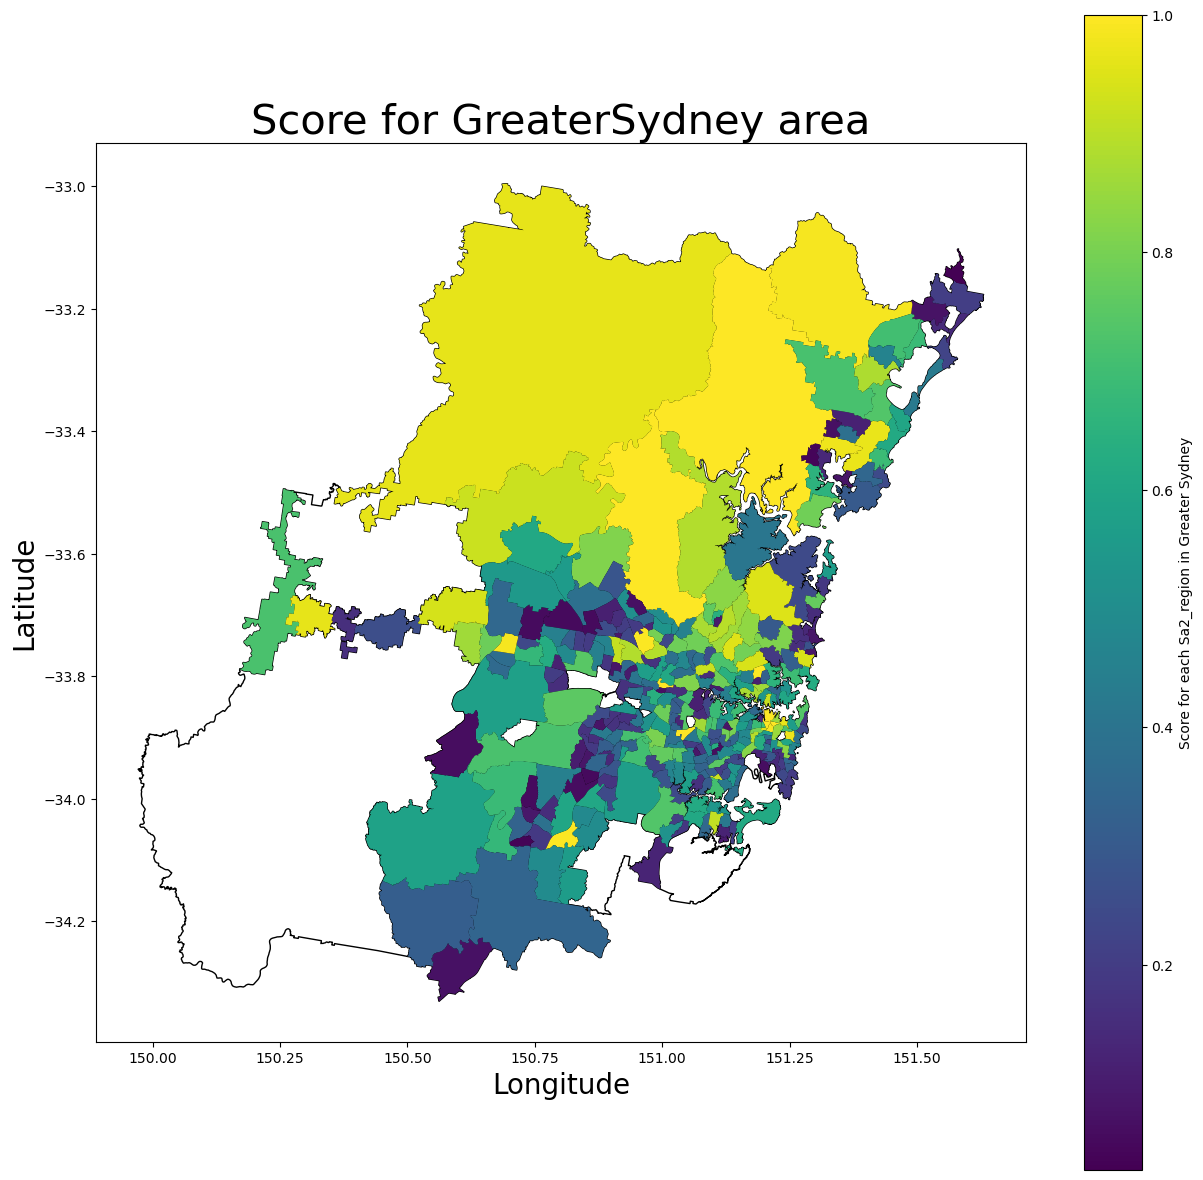

In [11]:
# plot the score_t2 dataframe on the sa2 dataframe, set the name for xlabel,ylabel, title and legend

fig, ax = plt.subplots(figsize = (15,15))
sa2_df.to_crs(epsg=4326).plot(ax=ax , color = 'white',edgecolor="black")

ax.set_title('Score for GreaterSydney area',fontdict = {'fontsize': 30})
ax.set_ylabel('Latitude',fontdict = {'fontsize': 20})
ax.set_xlabel('Longitude',fontdict = {'fontsize': 20})
score_t2.plot(ax=ax ,column='score', legend=True ,
             legend_kwds={"label": "Score for each Sa2_region in Greater Sydney"})




In [12]:
correlation = incomes_df[["sa2_code","median_income"]].merge(score_t2[['sa2_code','score','geometry']],on = 'sa2_code')
correlation = gpd.GeoDataFrame(correlation , geometry = correlation['geometry'],crs='epsg:4326' )
correlation['median_income'] = correlation['median_income'].astype(int)
corr = correlation['score'].corr(correlation['median_income'])

print("Correlation between Score and median income:", corr)

Correlation between Score and median income: 0.17681845755729755


In [13]:
score_with_median_income_t2 = score_t2.merge(correlation, on="sa2_code")

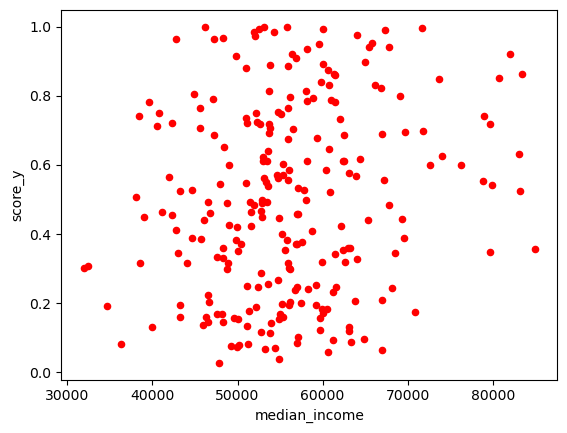

In [14]:
ax2 = score_with_median_income_t2.plot.scatter(x='median_income', y='score_y', c='Red')


# Extra data set for task3  

In [15]:
# https://opendata.transport.nsw.gov.au/dataset/traffic-lights-location
conn.execute("""

drop table if exists traffic_lights;
create table traffic_lights(
Asset_Type              varchar(50),
Equipment_ID             integer primary key,
Date_Install    date,
Longitude              float,
Latitude               float,
STREET_1               varchar(50),
STREET_2               varchar(50),
Suburb                 varchar(50),
RMS_Region             varchar(50),
geom      GEOMETRY(Point,4326)
)""")
# create table for traffic lights locations
traffic_lights_df = pd.read_excel("Traffic Lights Location Data May 2021.xlsx")
traffic_lights_df['geom'] = gpd.points_from_xy(traffic_lights_df.Longitude , traffic_lights_df.Latitude)
traffic_lights_df['geom'] = traffic_lights_df['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid)) 
traffic_lights_df  = traffic_lights_df.rename(columns=str.lower)
traffic_lights_df.to_sql('traffic_lights', conn, if_exists='append',index=False ,dtype={'geom': Geometry('Point', srid)})
# load the dataset as a dataframe from excel, create , convert geom column to wkt element , change the column name
# to lower case and load the data into the table

325

In [16]:
traffic_lights_sa2 = pd.read_sql("""select sa2_code , count(equipment_id)  from traffic_lights s right outer join sa2_region r on(ST_Contains(r.geom,s.geom)) 
group by sa2_code """,conn)
# count the number of traffic lights for each region
traffic_lights_sa2['traffic_lights_zscore']= zscore(traffic_lights_sa2['count'])
traffic_lights_sa2=traffic_lights_sa2.drop(columns = 'count')
traffic_lights_sa2
# calculate the zscore for number of traffic lights for each region

,sa2_code,traffic_lights_zscore
0,102011028,-1.109449
1,102011029,-0.870796
2,102011030,-0.393490
3,102011031,0.919103
4,102011032,1.993042
...,...,...
368,128021537,-0.870796
369,128021538,0.799776
370,128021607,-0.870796
371,128021608,-0.990123


In [17]:
building_value_df = pd.read_excel("value_of_building.xlsx")
# read the value of building in each region as a dataframe

In [18]:
conn.execute("""

drop table if exists building_value;
create table building_value(
sa2_code                                                                            integer primary key,
suburb                                                                             varchar(80),
New_houses                                                                          integer,
New_other_residential_building                                                      integer,
Total_dwellings                                                                     integer,
Value_of_new_houses                                                               float,
Value_of_new_other_residential_building                                           float,
Value_of_alterations_additions_including_conversions_to_residential_building    float,
Value_of_total_residential_building                                               float,
Value_of_non_residential_building                                                 float,
Value_of_total_building                                                           float

)""")
# create table for table value in each region

In [19]:
building_value_df= building_value_df.rename(columns=str.lower)
building_value_df.to_sql('building_value', conn, if_exists='append',index=False)
# load the data into the database, rename the columns to lower case

307

In [20]:
building_df =  pd.read_sql('select sa2_code ,value_of_total_building from building_value',conn)
building_df['building_zscore'] = zscore(building_df['value_of_total_building'])

building_df=building_df.drop(columns = 'value_of_total_building')

#  find the total value of the buildings for each reagion and calculate the zscore for them

In [21]:
import requests
import json
import pandas as pd
import time as t
import math


education_level_json_df = json.loads(requests.get("https://api.data.abs.gov.au/data/ABS,C21_G16_SA2,/3.1.25_34..SA2.1?startPeriod=2021&&format=jsondata").text)
population = education_level_json_df['data']['structure']["dimensions"]["series"][3]["values"]


keepgoing = True  # establishing a simple variable indicating if the looping should continue
URL = 'https://api.data.abs.gov.au/data/ABS,C21_G16_SA2,/3.1.25_34..SA2.1?startPeriod=2021&&format=jsondata'  # our base URL to begin with
SA2_areas_name = []  # an empty list ready to store our results as we go
SA2_areas_code = []

length = len(population)
i = 0
jsonURL = json.loads(requests.get(URL).text)

print('Data loading begins...')
while i < length:
    SA2 = jsonURL['data']['structure']["dimensions"]["series"][3]["values"][i]["name"]
    code = jsonURL['data']['structure']["dimensions"]["series"][3]["values"][i]["id"]

    SA2_areas_name.append(SA2)
    SA2_areas_code.append(int(code))
    i += 1;

observations = []
for item in education_level_json_df["data"]["dataSets"][0]["series"]:
    for value in education_level_json_df["data"]["dataSets"][0]["series"][item]["observations"]:
        
        observations += education_level_json_df["data"]["dataSets"][0]["series"][item]["observations"][value]
print('Data loading finished')


Data loading begins...
Data loading finished


In [22]:
url = "https://api.data.abs.gov.au/data/ABS,C21_G16_SA2,/3._T.25_34..SA2.1?startPeriod=2021&&format=jsondata"
                                   
total_25_to_34 = json.loads(requests.get(url).text)




SA2_area_code_for_total = []

print('Data loading begins...')
length = len(total_25_to_34['data']['structure']["dimensions"]["series"][3]["values"])
i = 0

while i < length:
    code = total_25_to_34['data']['structure']["dimensions"]["series"][3]["values"][i]["id"]
    SA2_area_code_for_total.append(int(code))
    i += 1;

total = []
for item in total_25_to_34["data"]["dataSets"][0]["series"]:
    for value in total_25_to_34["data"]["dataSets"][0]["series"][item]["observations"]:
        total += total_25_to_34["data"]["dataSets"][0]["series"][item]["observations"][value]


oragnised_totals = []
total_percent_who_have_finished_yr_12 = []

i=0
for code in SA2_areas_code:
    index = SA2_area_code_for_total.index(code)
    oragnised_totals.append(total[index])

while i <len(oragnised_totals):
    if oragnised_totals[i] >0:
        value = int((observations[i] / oragnised_totals[i])*100)
        total_percent_who_have_finished_yr_12.append(math.trunc(value))  
    else:
        total_percent_who_have_finished_yr_12.append(0);
    i += 1 
print('Data loading finished')

Data loading begins...
Data loading finished


In [23]:
values = {'sa2_code': SA2_areas_code, 'Name': SA2_areas_name, 'people_25_to_34_finished_year_12': observations,
         'total_people_25_to_34': oragnised_totals, 'finished_yr_12_percent' : total_percent_who_have_finished_yr_12}

educationLevels_df = pd.DataFrame(values)

In [24]:
conn.execute("""
drop table if exists education;
create table education(
sa2_code                                                                            integer primary key,
name                                                                             varchar(80),
people_25_to_34_finished_year_12                                                                          integer,
total_people_25_to_34                                                      integer,
finished_yr_12_percent                                                                     integer
);
""")

print('successfully created shema and tables')

successfully created shema and tables


In [25]:
educationLevels_df = educationLevels_df.rename(columns=str.lower)
educationLevels_df.to_sql('education', conn, if_exists='append',index=False)

644

In [26]:
educationLevels_df['finished_yr_12_percent_z_score'] = zscore(educationLevels_df['finished_yr_12_percent'])
educationLevels_df=educationLevels_df.drop(columns = ['name', 'people_25_to_34_finished_year_12','total_people_25_to_34','finished_yr_12_percent'])

educationLevels_df

,sa2_code,finished_yr_12_percent_z_score
0,110011188,-0.171978
1,117031646,0.958741
2,105011095,-0.398122
3,119031374,0.902205
4,116021562,1.015277
...,...,...
639,123021437,-0.002370
640,125021478,0.845669
641,109031185,-0.567730
642,128011602,0.449918


In [32]:
score_t3 = retail_bus_per1000.merge(health_bus_per1000,on='sa2_code').merge(stops_sa2,on='sa2_code').merge(polls_sa2,on='sa2_code').merge(school_sa2,on='sa2_code').merge(traffic_lights_sa2, on ='sa2_code').merge(building_df,on='sa2_code').merge(educationLevels_df, on='sa2_code').merge(sa2_df, on = 'sa2_code')

score_t3['sum_zscore'] = score_t3['retail_zscore']+score_t3['health_zscore']+score_t3['stops_zscore']+score_t3['polls_zscore']+score_t3['school_zscore']+score_t3['traffic_lights_zscore']+score_t3['building_zscore']+score_t3['finished_yr_12_percent_z_score']

score_t3['score'] = score_t3['sum_zscore'].apply(lambda x: sigmoid(x) )

score_t3 = score_t3[["sa2_code","retail_zscore","health_zscore","stops_zscore","polls_zscore","school_zscore",'traffic_lights_zscore','building_zscore',"finished_yr_12_percent_z_score","sum_zscore","score",'geometry']]
score_t3 = gpd.GeoDataFrame(score_t3 , geometry = score_t3['geometry'],crs='epsg:4326' )
score_t3

,sa2_code,retail_zscore,health_zscore,stops_zscore,polls_zscore,school_zscore,traffic_lights_zscore,building_zscore,finished_yr_12_percent_z_score,sum_zscore,score,geometry
0,102011028,-0.148716,0.214611,-0.258474,-0.502168,-0.426691,-1.109449,-0.362427,0.506454,-2.086860,0.110381,"POLYGON ((151.41373 -33.46558, 151.41362 -33.4..."
1,102011029,-0.300915,-0.381550,0.759299,-0.502168,-0.425431,-0.870796,-0.376584,0.223774,-1.874370,0.133037,"POLYGON ((151.37484 -33.50052, 151.37507 -33.5..."
2,102011030,0.483228,0.119868,0.261978,0.710971,7.192068,-0.393490,-0.430682,-0.228514,7.715426,0.999554,"MULTIPOLYGON (((151.20449 -33.53280, 151.20448..."
3,102011031,0.301173,0.692200,1.568892,0.468343,0.351767,0.919103,-0.323954,0.393382,4.370905,0.987518,"POLYGON ((151.37194 -33.43698, 151.37288 -33.4..."
4,102011032,0.108759,0.751346,2.378484,0.710971,-0.307435,1.993042,0.132040,0.393382,6.160588,0.997893,"POLYGON ((151.32349 -33.42779, 151.32342 -33.4..."
...,...,...,...,...,...,...,...,...,...,...,...,...
240,128021536,-0.325581,-0.460522,1.210358,0.710971,-0.658191,-0.632143,-0.293663,0.732597,0.283826,0.570484,"POLYGON ((151.07861 -33.99748, 151.07861 -33.9..."
241,128021538,-0.218936,-0.057045,0.527987,0.468343,-0.263499,0.799776,0.124288,0.732597,2.113512,0.892210,"POLYGON ((151.05006 -34.02158, 151.05008 -34.0..."
242,128021607,-0.364990,-0.448632,0.828693,0.710971,-0.640406,-0.870796,-0.305997,0.562990,-0.528169,0.370944,"POLYGON ((150.99568 -34.05361, 150.99570 -34.0..."
243,128021608,-0.361776,-0.625489,-0.061859,-0.502168,0.049021,-0.990123,-0.481177,0.619526,-2.354045,0.086745,"POLYGON ((151.03955 -34.04175, 151.03954 -34.0..."


<AxesSubplot:title={'center':'Score for GreaterSydney area'}, xlabel='Longitude', ylabel='Latitude'>

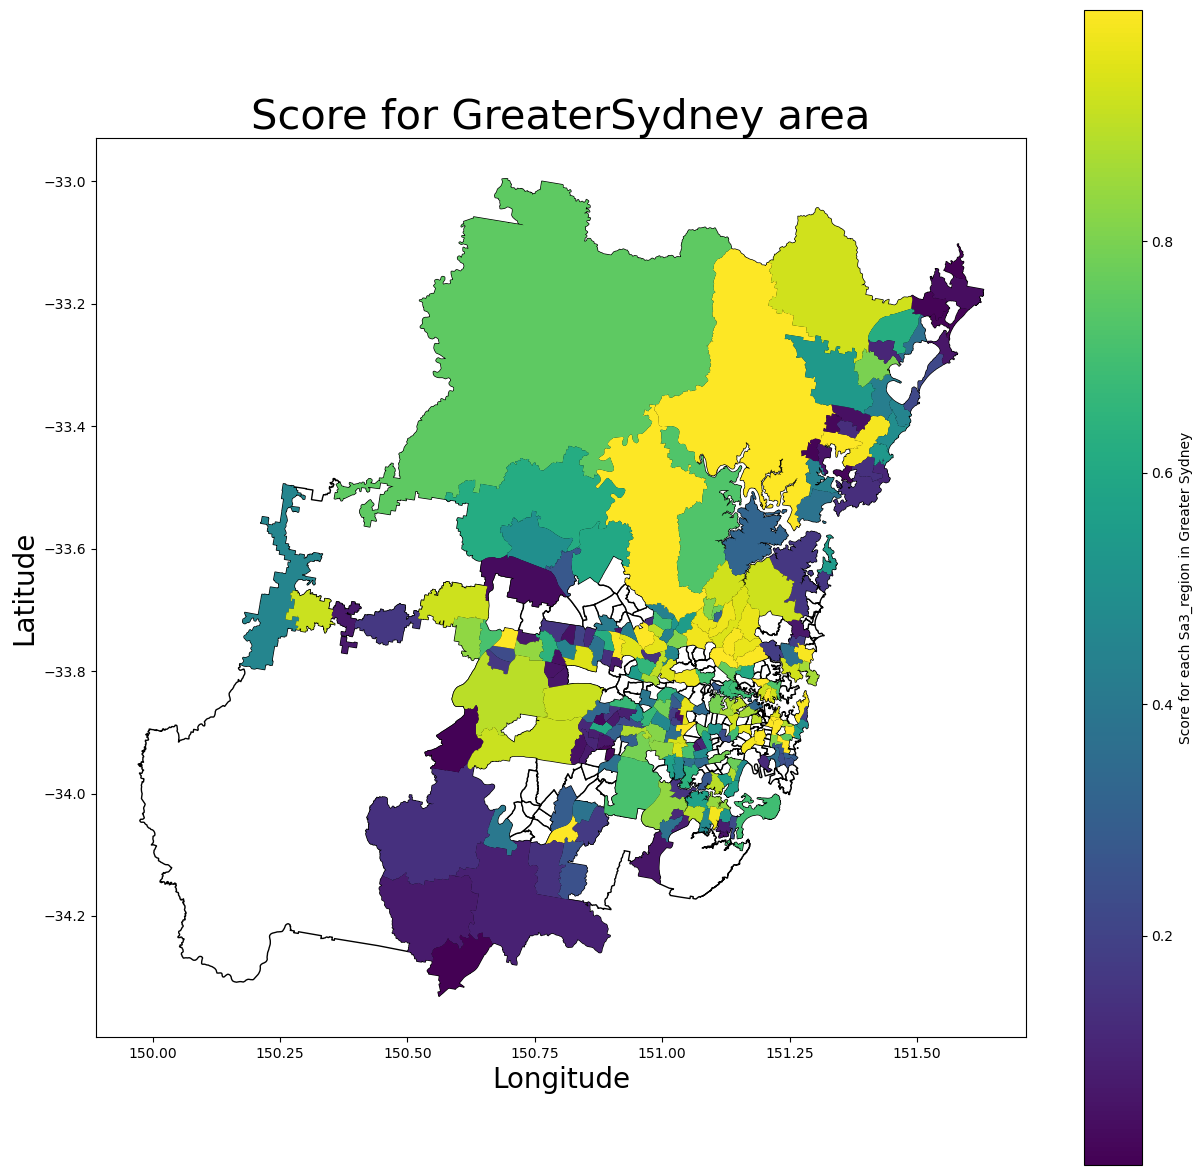

In [28]:
fig, ax = plt.subplots(figsize = (15,15))
sa2_df.to_crs(epsg=4326).plot(ax=ax , color = 'white',edgecolor="black")

ax.set_title('Score for GreaterSydney area',fontdict = {'fontsize': 30})
ax.set_ylabel('Latitude',fontdict = {'fontsize': 20})
ax.set_xlabel('Longitude',fontdict = {'fontsize': 20})
score_t3.plot(ax=ax ,column='score', legend=True ,
            legend_kwds={"label": "Score for each Sa3_region in Greater Sydney"})




In [29]:
corr = score_t3['score'].corr(correlation['median_income'])
print("Correlation between Score and median income:", corr)

Correlation between Score and median income: 0.30514938723153384


In [30]:
score_with_median_income_t3 = score_t3.merge(correlation, on="sa2_code")


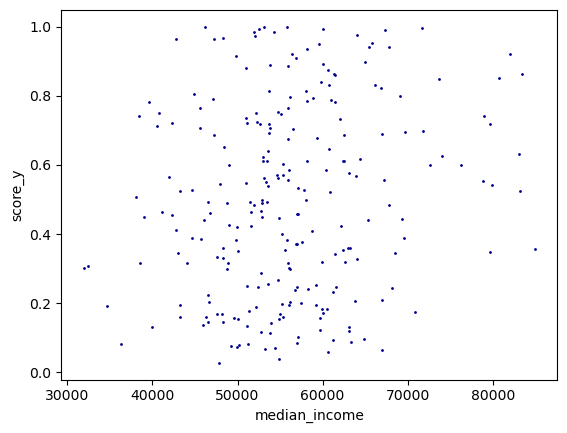

In [31]:
ax3 = score_with_median_income_t3.plot.scatter(x='median_income', y='score_y', s=1,  c='DarkBlue')
